In [1]:
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from tensorflow.keras.datasets import reuters
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

warnings.filterwarnings(action='ignore')

## 데이터 로드

In [2]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

2121728/2110848 [==============================] - 0s 0us/step


In [3]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [4]:
print(x_train[0])
print(x_test[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 192, 510, 17, 12]


In [5]:
print(y_train[0])
print(y_test[0])

3
3


In [6]:
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


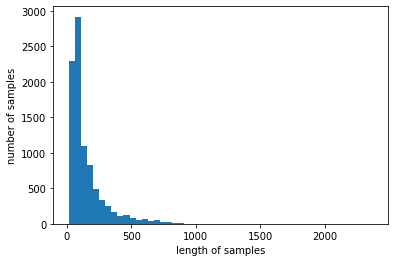

In [7]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [8]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


In [9]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
print('=3')

565248/550378 [==============================] - 0s 0us/step
=3


In [10]:
word_index['the']

1

In [11]:
index_to_word = { index+3 : word for word, index in word_index.items() }
print('=3')

=3


In [12]:
print(index_to_word[4])
print(index_to_word[16])

the
it


In [13]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token
print('=3')

=3


In [14]:
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [15]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [16]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

2246


In [17]:
x_train[:5]

['<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3',
 '<sos> generale de banque sa lt <unk> br and lt heller overseas corp of chicago have each taken 50 pct stakes in <unk> company sa <unk> factors generale de banque said in a statement it gave no financial details of the transaction sa <unk> <unk> turnover in 1986 was 17 5 billion belgian francs reuter 3',
 '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect the two for o

In [18]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 9670)


In [19]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 9670)


In [20]:
# 모델 별 정확도, f1_score 저장용
accuracy_10000 = {}
f1_10000 = {}

In [21]:
model = MultinomialNB()
model.fit(tfidfv, y_train)

MultinomialNB()

In [22]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = model.predict(tfidfv_test) #테스트 데이터에 대한 예측
accuracy_10000['Multinomial Naive Bayes Classifier'] = accuracy_score(y_test, predicted)
report = classification_report(y_test, predicted, output_dict=True, zero_division=0)
f1_10000['Multinomial Naive Bayes Classifier'] = report['weighted avg']['f1-score']
print(f"정확도:, {accuracy_10000['Multinomial Naive Bayes Classifier']}\nF1-score: {f1_10000['Multinomial Naive Bayes Classifier']}") #예측값과 실제값 비교

정확도:, 0.6567230632235085
F1-score: 0.5764467518778252


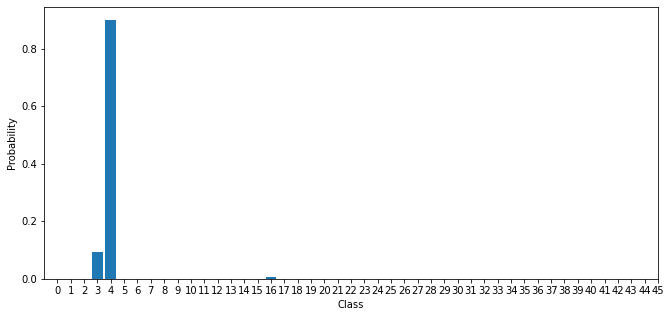

In [23]:
probability_3 = model.predict_proba(tfidfv_test[3])[0]

plt.rcParams["figure.figsize"] = (11,5)
plt.bar(model.classes_, probability_3)
plt.xlim(-1, 21)
plt.xticks(model.classes_)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.show()

In [24]:
model.predict(tfidfv_test[3])

array([4])

In [25]:
print(classification_report(y_test, model.predict(tfidfv_test), zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.62      0.69      0.65       105
           2       0.00      0.00      0.00        20
           3       0.81      0.90      0.85       813
           4       0.51      0.96      0.67       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.08      0.15        25
          10       0.00      0.00      0.00        30
          11       0.66      0.63      0.64        83
          12       0.00      0.00      0.00        13
          13       1.00      0.03      0.05        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.69      0.56      0.61        99
          17       0.00    

In [26]:
report = classification_report(y_test, model.predict(tfidfv_test), output_dict=True, zero_division=0)

In [27]:
report['weighted avg']['f1-score']

0.5764467518778252

In [28]:
def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
    df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
    fig = plt.figure(figsize=(12,12))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
    plt.ylabel('label')
    plt.xlabel('predicted value')

print('=3')

=3


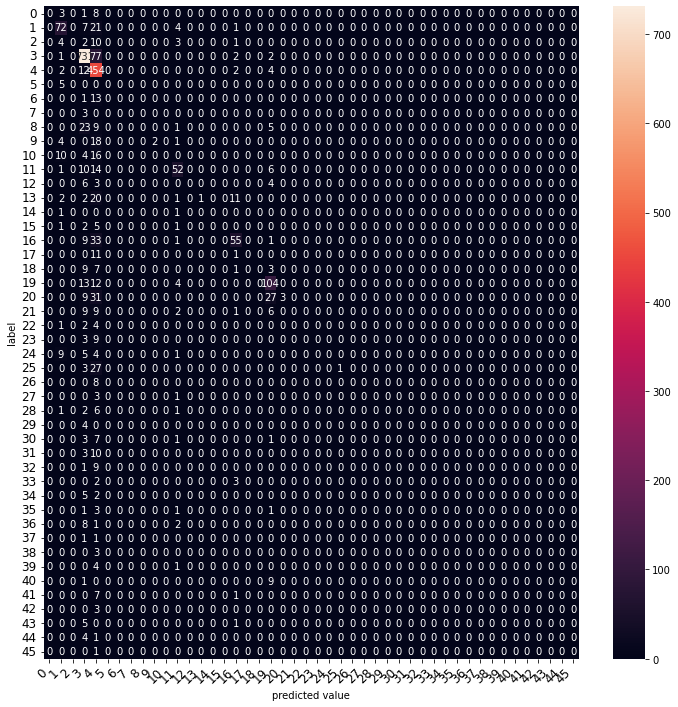

In [29]:
graph_confusion_matrix(model, tfidfv_test, y_test)

In [30]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [31]:
predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
accuracy_10000['Complement Naive Bayes Classifier'] = accuracy_score(y_test, predicted)
report = classification_report(y_test, predicted, output_dict=True, zero_division=0)
f1_10000['Complement Naive Bayes Classifier'] = report['weighted avg']['f1-score']
print(f"정확도:, {accuracy_10000['Complement Naive Bayes Classifier']}\nF1-score: {f1_10000['Complement Naive Bayes Classifier']}") #예측값과 실제값 비교

정확도:, 0.7707034728406055
F1-score: 0.7456682614453047


In [32]:
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

LogisticRegression(C=10000)

In [33]:
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
accuracy_10000['Logistic Regression'] = accuracy_score(y_test, predicted)
report = classification_report(y_test, predicted, output_dict=True, zero_division=0)
f1_10000['Logistic Regression'] = report['weighted avg']['f1-score']
print(f"정확도:, {accuracy_10000['Logistic Regression']}\nF1-score: {f1_10000['Logistic Regression']}") #예측값과 실제값 비교

정확도:, 0.8076580587711487
F1-score: 0.8014651882605348


In [34]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

LinearSVC(C=1000, dual=False, max_iter=500, penalty='l1')

In [35]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
accuracy_10000['Linear Support Vector Machine'] = accuracy_score(y_test, predicted)
report = classification_report(y_test, predicted, output_dict=True, zero_division=0)
f1_10000['Linear Support Vector Machine'] = report['weighted avg']['f1-score']
print(f"정확도:, {accuracy_10000['Linear Support Vector Machine']}\nF1-score: {f1_10000['Linear Support Vector Machine']}") #예측값과 실제값 비교

정확도:, 0.7711487088156723
F1-score: 0.7660242378020207


In [36]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [37]:
predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
accuracy_10000['Decision Tree'] = accuracy_score(y_test, predicted)
report = classification_report(y_test, predicted, output_dict=True, zero_division=0)
f1_10000['Decision Tree'] = report['weighted avg']['f1-score']
print(f"정확도:, {accuracy_10000['Decision Tree']}\nF1-score: {f1_10000['Decision Tree']}") #예측값과 실제값 비교

정확도:, 0.6202137132680321
F1-score: 0.5776398779280149


In [38]:
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [39]:
predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
accuracy_10000['Random Forest'] = accuracy_score(y_test, predicted)
report = classification_report(y_test, predicted, output_dict=True, zero_division=0)
f1_10000['Random Forest'] = report['weighted avg']['f1-score']
print(f"정확도:, {accuracy_10000['Random Forest']}\nF1-score: {f1_10000['Random Forest']}")

정확도:, 0.674087266251113
F1-score: 0.6429484177284822


In [40]:
grbt = GradientBoostingClassifier(random_state=0,)
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(random_state=0)

In [41]:
predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
accuracy_10000['GradientBoostingClassifier'] = accuracy_score(y_test, predicted)
report = classification_report(y_test, predicted, output_dict=True, zero_division=0)
f1_10000['GradientBoostingClassifier'] = report['weighted avg']['f1-score']
print(f"정확도:, {accuracy_10000['GradientBoostingClassifier']}\nF1-score: {f1_10000['GradientBoostingClassifier']}") #예측값과 실제값 비교

정확도:, 0.7662511130899377
F1-score: 0.7622247724249729


In [42]:
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('lr', LogisticRegression(C=10000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft')

In [44]:
predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
accuracy_10000['Voting'] = accuracy_score(y_test, predicted)
report = classification_report(y_test, predicted, output_dict=True, zero_division=0)
f1_10000['Voting'] = report['weighted avg']['f1-score']
print(f"정확도:, {accuracy_10000['Voting']}\nF1-score: {f1_10000['Voting']}") #예측값과 실제값 비교

정확도:, 0.8116651825467498
F1-score: 0.8082216149049796


## 단어 수 변경하며 비교

위에서 진행한 과정을 각각의 함수로 생성한 후, 단어의 수를 바꿔가며 성능의 변화를 파악한다.

### 데이터 업로드, 복원 및 벡터화

In [45]:
def set_train_test(num_words=10000, rate=0.2,):
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=rate)
    
    return x_train, y_train, x_test, y_test

def train_test_info(x_train, y_train, x_test, y_test):
    print('훈련 샘플의 수: {}'.format(len(x_train)))
    print('테스트 샘플의 수: {}'.format(len(x_test)))
    num_classes = max(y_train) + 1
    print('클래스의 수 : {}'.format(num_classes))
    
    print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
    print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

    plt.hist([len(s) for s in x_train], bins=50)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()
    
    fig, axe = plt.subplots(ncols=1)
    fig.set_size_inches(11,5)
    sns.countplot(x=y_train)
    plt.show()
    
    unique_elements, counts_elements = np.unique(y_train, return_counts=True)
    print("각 클래스 빈도수:")
    print(np.asarray((unique_elements, counts_elements)))

def return_data(x_train, x_test):
    word_index = reuters.get_word_index(path="reuters_word_index.json")
    index_to_word = { index+3 : word for word, index in word_index.items() }
    for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
        index_to_word[index]=token
        
    tr_decoded = []
    for i in range(len(x_train)):
        t = ' '.join([index_to_word[index] for index in x_train[i]])
        tr_decoded.append(t)

    x_train = tr_decoded
    print(f"x_train: {len(x_train)}")
    
    ts_decoded = []
    for i in range(len(x_test)):
        t = ' '.join([index_to_word[index] for index in x_test[i]])
        ts_decoded.append(t)

    x_test = ts_decoded
    print(f"x_test: {len(x_test)}")
    
    return x_train, x_test

def dtm_tf_idf(x_train, x_test):
    dtmvector = CountVectorizer()
    x_train_dtm = dtmvector.fit_transform(x_train)
    print(x_train_dtm.shape)
    
    tfidf_transformer = TfidfTransformer()
    tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
    print(tfidfv.shape)
    
    return dtmvector, x_train_dtm, tfidf_transformer, tfidfv

### 모델 학습

In [46]:
def train_model(dtmvector, x_train_dtm, tfidf_transformer, tfidfv, x_test, y_train):
    accuracy = {}
    f1_score = {}
    # 나이브 베이즈 분류기
    naive = MultinomialNB()
    naive.fit(tfidfv, y_train)
    
    x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
    tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

    predicted = naive.predict(tfidfv_test) #테스트 데이터에 대한 예측
    accuracy['Multinomial Naive Bayes Classifier'] = accuracy_score(y_test, predicted)
    report = classification_report(y_test, predicted, output_dict=True, zero_division=0)
    f1_score['Multinomial Naive Bayes Classifier'] = report['weighted avg']['f1-score']
    print("Multinomial Naive Bayes Classifier Done")
    
    # 컴플리먼트 나이브 베이즈 분류기

    cb = ComplementNB()
    cb.fit(tfidfv, y_train)
    
    predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
    accuracy['Complement Naive Bayes Classifier'] = accuracy_score(y_test, predicted)
    report = classification_report(y_test, predicted, output_dict=True, zero_division=0)
    f1_score['Complement Naive Bayes Classifier'] = report['weighted avg']['f1-score']
    print("Complement Naive Bayes Classifier Done")
    
    
    # 로지스틱 회귀 
    lr = LogisticRegression(C=10000, penalty='l2')
    lr.fit(tfidfv, y_train)
    
    predicted = lr.predict(tfidfv_test) 
    accuracy['Logistic Regression'] = accuracy_score(y_test, predicted)
    report = classification_report(y_test, predicted, output_dict=True, zero_division=0)
    f1_score['Logistic Regression'] = report['weighted avg']['f1-score']
    print("Logistic Regression Done")
    
    # 서포트 벡터 머신
    lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
    lsvc.fit(tfidfv, y_train)
    
    predicted = lsvc.predict(tfidfv_test) 
    accuracy['Linear Support Vector Machine'] = accuracy_score(y_test, predicted)
    report = classification_report(y_test, predicted, output_dict=True, zero_division=0)
    f1_score['Linear Support Vector Machine'] = report['weighted avg']['f1-score']
    print("Linear Support Vector Machine Done")
    
    # 결정트리
    tree = DecisionTreeClassifier(max_depth=10, random_state=0)
    tree.fit(tfidfv, y_train)
    
    predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
    accuracy['Decision Tree'] = accuracy_score(y_test, predicted)
    report = classification_report(y_test, predicted, output_dict=True, zero_division=0)
    f1_score['Decision Tree'] = report['weighted avg']['f1-score']
    print("Decision Tree Done")
    
    # 랜덤 포레스트
    forest = RandomForestClassifier(n_estimators=5, random_state=0)
    forest.fit(tfidfv, y_train)
    
    predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
    accuracy['Random Forest'] = accuracy_score(y_test, predicted)
    report = classification_report(y_test, predicted, output_dict=True, zero_division=0)
    f1_score['Random Forest'] = report['weighted avg']['f1-score']
    print("Random Forest Done")
    
    # 그라디언트 부스팅
    grbt = GradientBoostingClassifier(random_state=0) # verbose=3
    grbt.fit(tfidfv, y_train)
    
    predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
    accuracy['GradientBoostingClassifier'] = accuracy_score(y_test, predicted)
    report = classification_report(y_test, predicted, output_dict=True, zero_division=0)
    f1_score['GradientBoostingClassifier'] = report['weighted avg']['f1-score']
    print("GradientBoostingClassifier Done")
    
    # 보팅
    voting_classifier = VotingClassifier(estimators=[
             ('lr', LogisticRegression(C=10000, penalty='l2')),
            ('cb', ComplementNB()),
            ('grbt', GradientBoostingClassifier(random_state=0))
    ], voting='soft', n_jobs=-1)
    voting_classifier.fit(tfidfv, y_train)

    predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
    accuracy['Voting'] = accuracy_score(y_test, predicted)
    report = classification_report(y_test, predicted, output_dict=True, zero_division=0)
    f1_score['Voting'] = report['weighted avg']['f1-score']
    print("Voting Done")
    
    return accuracy, f1_score

### Num_words = 5000

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246
클래스의 수 : 46
훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


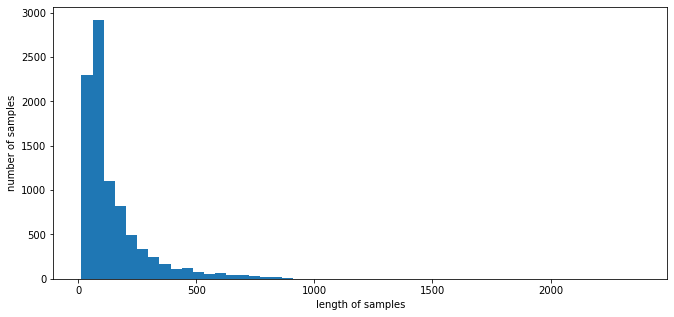

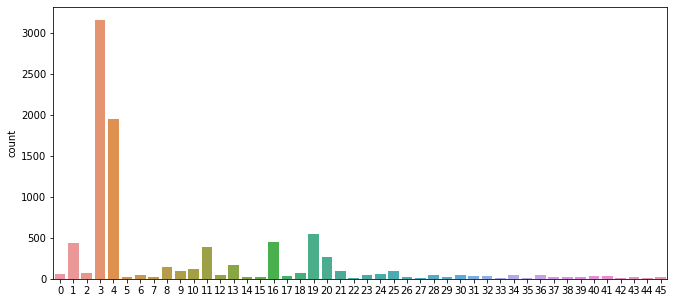

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]
x_train: 8982
x_test: 2246
(8982, 4867)
(8982, 4867)
Multinomial Naive Bayes Classifier Done
Complement Naive Bayes Classifier Done
Logistic Regression Done
Linear Support Vector Machine Done
Decision Tree Done
Random Forest Done
GradientBoostingClassifier Done


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting Done


In [47]:
x_train, y_train, x_test, y_test = set_train_test(5000, 0.2)
train_test_info(x_train, y_train, x_test, y_test)
x_train, x_test = return_data(x_train, x_test)
dtmvector, x_train_dtm, tfidf_transformer, tfidfv = dtm_tf_idf(x_train, x_test)

accuracy_5000, f1_5000 = train_model(dtmvector, x_train_dtm, tfidf_transformer, tfidfv, x_test, y_train)

### Num_words = None (모든 단어 사용)

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246
클래스의 수 : 46
훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


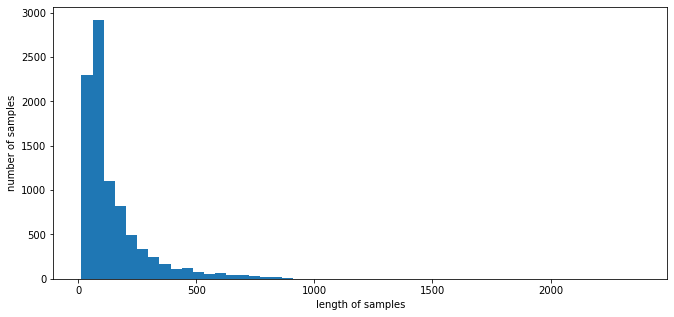

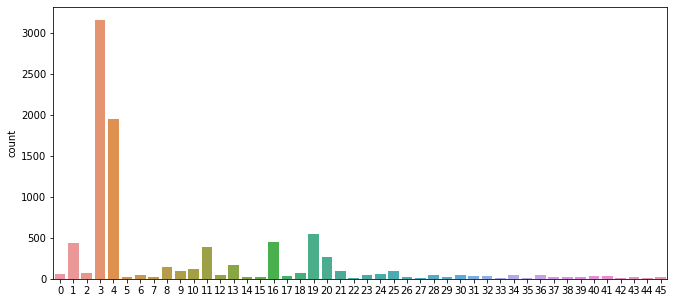

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]
x_train: 8982
x_test: 2246
(8982, 26506)
(8982, 26506)
Multinomial Naive Bayes Classifier Done
Complement Naive Bayes Classifier Done
Logistic Regression Done
Linear Support Vector Machine Done
Decision Tree Done
Random Forest Done
GradientBoostingClassifier Done


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting Done


In [48]:
x_train, y_train, x_test, y_test = set_train_test(None, 0.2)
train_test_info(x_train, y_train, x_test, y_test)
x_train, x_test = return_data(x_train, x_test)
dtmvector, x_train_dtm, tfidf_transformer, tfidfv = dtm_tf_idf(x_train, x_test)

accuracy_none, f1_none = train_model(dtmvector, x_train_dtm, tfidf_transformer, tfidfv, x_test, y_train)

## 딥러닝 모델과 비교

In [49]:
x_train, y_train, x_test, y_test = set_train_test(10000, 0.2)

In [50]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [51]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
index_to_word = { index+3 : word for word, index in word_index.items() }
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token
    
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [52]:
x_train = tensorflow.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=0,
                                                        padding='pre',
                                                        maxlen=200)

x_test = tensorflow.keras.preprocessing.sequence.pad_sequences(x_test,
                                                        value=0,
                                                        padding='pre',
                                                        maxlen=200)

In [53]:
print('X_train의 크기(shape) :',x_train.shape)
print('X_test의 크기(shape) :',x_test.shape)

X_train의 크기(shape) : (8982, 200)
X_test의 크기(shape) : (2246, 200)


In [54]:
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    1,    2,    2,    8,   43,   10,  447,    5,
         25,  207,  270,    5, 3095,  111,   16,  369,  186,   90,   67,
          7,   89,    5,   19,  102,    6,   19,  124,   15,   90,   67,
         84,   22,  482,   26,    7,   48,    4,   

In [55]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [56]:
y_train[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [57]:
y_train.shape

(8982, 46)

In [58]:
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000 
word_vector_dim = 200

lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm_model.add(tf.keras.layers.LSTM(128)) 
lstm_model.add(tf.keras.layers.Dense(64, activation='relu'))
lstm_model.add(tf.keras.layers.Dense(46, activation='sigmoid'))

lstm_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               168448    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 46)                2990      
Total params: 2,179,694
Trainable params: 2,179,694
Non-trainable params: 0
_________________________________________________________________


[f1score 함수 출처](https://m.blog.naver.com/wideeyed/221226716255)

In [61]:
from keras import backend as K
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision
def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [62]:
lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1score])
              
epochs=10

lstm_history = lstm_model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=32,
                    validation_data=(x_test, y_test),
                    verbose=1)

Epoch 1/10
281/281 [==============================] - 178s 618ms/step - loss: 0.1058 - accuracy: 0.3171 - f1score: 0.0023 - val_loss: 0.0726 - val_accuracy: 0.3620 - val_f1score: 0.0000e+00
Epoch 2/10
281/281 [==============================] - 172s 613ms/step - loss: 0.0697 - accuracy: 0.3852 - f1score: 0.1610 - val_loss: 0.0611 - val_accuracy: 0.4987 - val_f1score: 0.4333
Epoch 3/10
281/281 [==============================] - 172s 613ms/step - loss: 0.0593 - accuracy: 0.5118 - f1score: 0.4523 - val_loss: 0.0579 - val_accuracy: 0.5316 - val_f1score: 0.4968
Epoch 4/10
281/281 [==============================] - 171s 610ms/step - loss: 0.0570 - accuracy: 0.5360 - f1score: 0.4799 - val_loss: 0.0569 - val_accuracy: 0.5370 - val_f1score: 0.4982
Epoch 5/10
281/281 [==============================] - 170s 604ms/step - loss: 0.0561 - accuracy: 0.5461 - f1score: 0.4889 - val_loss: 0.0574 - val_accuracy: 0.5356 - val_f1score: 0.4823
Epoch 6/10
281/281 [==============================] - 167s 594ms/s

In [63]:
_loss, _accuracy, _f1_score = lstm_model.evaluate(x_test, y_test)

71/71 [==============================] - 10s 147ms/step - loss: 0.0444 - accuracy: 0.6447 - f1score: 0.6753


In [64]:
as_5000 = pd.Series(accuracy_5000)
as_10000 = pd.Series(accuracy_10000)
as_none = pd.Series(accuracy_none)

In [66]:
as_total = pd.concat([as_5000, as_10000, as_none], axis=1)

In [67]:
as_total.rename(columns={0: '5000', 1: '10000', 2:'None'}, inplace=True)

In [68]:
as_total

,5000,10000,None
Multinomial Naive Bayes Classifier,0.673197,0.656723,0.599733
Complement Naive Bayes Classifier,0.770703,0.770703,0.764915
Logistic Regression,0.805877,0.807658,0.813446
Linear Support Vector Machine,0.771149,0.771149,0.783170
Decision Tree,0.617988,0.620214,0.621104
Random Forest,0.701247,0.674087,0.654497
GradientBoostingClassifier,0.767587,0.766251,0.770258
Voting,0.816118,0.811665,0.818789


In [70]:
as_total.append(pd.Series([0, _accuracy, 0], name='LSTM', index=as_total.columns))

,5000,10000,None
Multinomial Naive Bayes Classifier,0.673197,0.656723,0.599733
Complement Naive Bayes Classifier,0.770703,0.770703,0.764915
Logistic Regression,0.805877,0.807658,0.813446
Linear Support Vector Machine,0.771149,0.771149,0.783170
Decision Tree,0.617988,0.620214,0.621104
Random Forest,0.701247,0.674087,0.654497
GradientBoostingClassifier,0.767587,0.766251,0.770258
Voting,0.816118,0.811665,0.818789
LSTM,0.000000,0.644702,0.000000


In [71]:
list_5000 = sorted(accuracy_5000.items(), key=lambda x: x[1], reverse=True)
print(f'5000단어를 사용했을 경우 정확도가 가장 높은 모델: {list_5000[0][0]}')
print(f'5000단어를 사용했을 경우 정확도가 가장 낮은 모델: {list_5000[-1][0]}')
print()
list_10000 = sorted(accuracy_10000.items(), key=lambda x: x[1], reverse=True)
print(f'10000단어를 사용했을 경우 정확도가 가장 높은 모델: {list_10000[0][0]}')
print(f'10000단어를 사용했을 경우 정확도가 가장 낮은 모델: {list_10000[-1][0]}')
print()
list_none = sorted(accuracy_none.items(), key=lambda x: x[1], reverse=True)
print(f'모든 단어를 사용했을 경우 정확도가 가장 높은 모델: {list_none[0][0]}')
print(f'모든 단어를 사용했을 경우 정확도가 가장 낮은 모델: {list_none[-1][0]}')
print()

5000단어를 사용했을 경우 정확도가 가장 높은 모델: Voting
5000단어를 사용했을 경우 정확도가 가장 낮은 모델: Decision Tree

10000단어를 사용했을 경우 정확도가 가장 높은 모델: Voting
10000단어를 사용했을 경우 정확도가 가장 낮은 모델: Decision Tree

모든 단어를 사용했을 경우 정확도가 가장 높은 모델: Voting
모든 단어를 사용했을 경우 정확도가 가장 낮은 모델: Multinomial Naive Bayes Classifier



In [72]:
fs_5000 = pd.Series(f1_5000)
fs_10000 = pd.Series(f1_10000)
fs_none = pd.Series(f1_none)

In [73]:
fs_total = pd.concat([fs_5000, fs_10000, fs_none], axis=1)

In [74]:
fs_total.rename(columns={0: '5000', 1: '10000', 2:'None'}, inplace=True)

In [75]:
fs_total

,5000,10000,None
Multinomial Naive Bayes Classifier,0.601250,0.576447,0.504567
Complement Naive Bayes Classifier,0.745899,0.745668,0.734653
Logistic Regression,0.799458,0.801465,0.807935
Linear Support Vector Machine,0.765669,0.766024,0.777576
Decision Tree,0.572997,0.577640,0.576928
Random Forest,0.677022,0.642948,0.622591
GradientBoostingClassifier,0.766248,0.762225,0.764167
Voting,0.812671,0.808222,0.814723


In [76]:
fs_total.append(pd.Series([0, _f1_score, 0], name='LSTM', index=fs_total.columns))

,5000,10000,None
Multinomial Naive Bayes Classifier,0.601250,0.576447,0.504567
Complement Naive Bayes Classifier,0.745899,0.745668,0.734653
Logistic Regression,0.799458,0.801465,0.807935
Linear Support Vector Machine,0.765669,0.766024,0.777576
Decision Tree,0.572997,0.577640,0.576928
Random Forest,0.677022,0.642948,0.622591
GradientBoostingClassifier,0.766248,0.762225,0.764167
Voting,0.812671,0.808222,0.814723
LSTM,0.000000,0.675323,0.000000


In [78]:
list_5000 = sorted(f1_5000.items(), key=lambda x: x[1], reverse=True)
print(f'5000단어를 사용했을 경우 f1-score가 가장 높은 모델: {list_5000[0][0]}')
print(f'5000단어를 사용했을 경우 f1-score가 가장 낮은 모델: {list_5000[-1][0]}')
print()
list_10000 = sorted(f1_10000.items(), key=lambda x: x[1], reverse=True)
print(f'10000단어를 사용했을 경우 f1-score가 가장 높은 모델: {list_10000[0][0]}')
print(f'10000단어를 사용했을 경우 f1-score가 가장 낮은 모델: {list_10000[-1][0]}')
print()
list_none = sorted(f1_none.items(), key=lambda x: x[1], reverse=True)
print(f'모든 단어를 사용했을 경우 f1-score가 가장 높은 모델: {list_none[0][0]}')
print(f'모든 단어를 사용했을 경우 f1-score가 가장 낮은 모델: {list_none[-1][0]}')
print()

5000단어를 사용했을 경우 f1-score가 가장 높은 모델: Voting
5000단어를 사용했을 경우 f1-score가 가장 낮은 모델: Decision Tree

10000단어를 사용했을 경우 f1-score가 가장 높은 모델: Voting
10000단어를 사용했을 경우 f1-score가 가장 낮은 모델: Multinomial Naive Bayes Classifier

모든 단어를 사용했을 경우 f1-score가 가장 높은 모델: Voting
모든 단어를 사용했을 경우 f1-score가 가장 낮은 모델: Multinomial Naive Bayes Classifier



## 회고
|Accuracy|F1-score|
|:-:|:-:|
|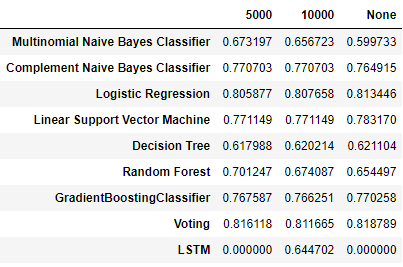|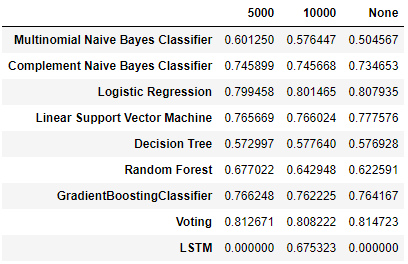|

단어의 수를 5000개, 10000개로 제한하거나 모두 사용해 각각의 모델에 학습시켰을 경우 위와 같은 정확도,f1-score를 보이는 것으로 나타났다. 그리고 가장 높은 값과 낮은 값을 정리하면 다음과 같았다.

#### Accuracy
5000단어를 사용했을 경우 정확도가 가장 높은 모델: Voting
5000단어를 사용했을 경우 정확도가 가장 낮은 모델: Decision Tree

10000단어를 사용했을 경우 정확도가 가장 높은 모델: Voting
10000단어를 사용했을 경우 정확도가 가장 낮은 모델: Decision Tree

모든 단어를 사용했을 경우 정확도가 가장 높은 모델: Voting
모든 단어를 사용했을 경우 정확도가 가장 낮은 모델: Multinomial Naive Bayes Classifier

#### F1-score
5000단어를 사용했을 경우 f1-score가 가장 높은 모델: Voting
5000단어를 사용했을 경우 f1-score가 가장 낮은 모델: Decision Tree

10000단어를 사용했을 경우 f1-score가 가장 높은 모델: Voting
10000단어를 사용했을 경우 f1-score가 가장 낮은 모델: Multinomial Naive Bayes Classifier

모든 단어를 사용했을 경우 f1-score가 가장 높은 모델: Voting
모든 단어를 사용했을 경우 f1-score가 가장 낮은 모델: Multinomial Naive Bayes Classifier

---
 정확도 측면에서 봤을 때 단어를 특정 수만큼 선별해 사용했을 경우엔 Decision Tree에서 가장 낮은 값을 보였지만, 모두 사용했을 경우엔 나이브 베이즈 분류기에서 가장 성능이 좋지 않았다. 세 경우 모두 Voting이 가장 좋은 성능을 나타냈다. 일반적으로 앙상블 방식이 성능이 좋다고 알려져있는데, 그러한 사실과 부합하는 결과였다. 
 F1-score 측면에서도 비슷한 결과가 나왔다. 5000개의 단어를 사용했을 땐 Voting이 가장 높은 반면 Decision Tree가 가장 낮은 성능을 보였고, 10000개의 단어를 선별했을 경우와 모든 단어를 사용했을 땐 Voting이 가장 높은 반면 나이브 베이즈 분류기가 가장 낮은 성능을 보이는 것으로 나타났다.
 
 결정트리가 가장 낮은 정확도를 보인 이유는 트리의 깊이를 따로 지정하지 않았기 때문이라고 생각한다. 일반적으로 결정트리는 깊이를 얕게 정해 과적합을 피하는데, 이러한 설정을 하지 않았기 때문에 과적합이 일어났다고 생각했다. 나이브 베이즈 분류기 같은 경우는 데이터의 수가 너무 적은 경우 과적합이 일어나 성능이 떨어질 수 있다고 하는데, 위의 경우엔 모든 단어를 사용했을 경우 오히려 정확도가 떨어져 해당되는 경우는 아닌 거 같다.

10000개의 단어만을 사용한 경우는 LSTM 모델을 추가해 비교했는데, 이 경우 다른 모델보다 좋은 성능을 보이지 못했다. train set에 대한 정확도도 높지 않게 나왔기 때문에 과적합이 일어나진 않은 것으로 보이며, epoch를 늘려 학습을 더 시켰다면 성능이 조금은 나아지지 않았을까 생각한다.  